### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 40        # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500 #123_000_000   # mass of the vessel, [kg]

In [8]:
lx, ly, lz = L/2, B/2, H/2

In [9]:
vessel_mass = mn/L # mass over length of the vessel

In [10]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [11]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [12]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [13]:
E = 210e9

In [14]:
h = 100 # water depth

In [15]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [16]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [17]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [18]:
# Constants: 

In [19]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [20]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [21]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [22]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [23]:
# for testing:

In [24]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [25]:
φ

array([0.84650514, 0.22998014, 0.13574545, 0.98513292, 0.04827467,
       0.64687948, 0.20960366, 0.27432032, 0.56090528, 0.36733073,
       0.12100578, 0.15053003, 0.14639693, 0.69755376, 0.29420535,
       0.57968372, 0.8418666 , 0.69121645, 0.51063042, 0.48249631,
       0.5959022 , 0.85854588, 0.7564208 , 0.81497689, 0.98981588,
       0.89207399, 0.85808327, 0.44959822, 0.96592258, 0.59140667,
       0.10003956, 0.8178062 , 0.72736263, 0.11531124, 0.11729301,
       0.26641172, 0.578372  , 0.89622794, 0.34583283, 0.18552232])

In [26]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [27]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [28]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [29]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

### Main functions:

In [30]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [31]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [32]:
Π(φ,θ,ψ)

array([[[ 0.66403793,  0.        ,  0.49542882],
        [ 0.        ,  1.        , -0.74896927],
        [-0.74769889,  0.        ,  0.43999467]],

       [[ 0.60527533,  0.        ,  0.77505781],
        [ 0.        ,  1.        , -0.22795819],
        [-0.79601619,  0.        ,  0.58933899]],

       [[ 0.70738821,  0.        ,  0.70032296],
        [ 0.        ,  1.        , -0.13532894],
        [-0.70682524,  0.        ,  0.70088075]],

       [[ 0.97296211,  0.        ,  0.12766632],
        [ 0.        ,  1.        , -0.83334557],
        [-0.23096477,  0.        ,  0.5378071 ]],

       [[ 0.99427979,  0.        ,  0.1066824 ],
        [ 0.        ,  1.        , -0.04825592],
        [-0.10680683,  0.        ,  0.99312146]],

       [[ 0.79229664,  0.        ,  0.48686932],
        [ 0.        ,  1.        , -0.60269927],
        [-0.61013607,  0.        ,  0.6322277 ]],

       [[ 0.98343628,  0.        ,  0.17728716],
        [ 0.        ,  1.        , -0.20807225],
        

In [33]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [34]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.59405646, -0.69307164,  0.32823391],
       [ 0.99970338,  0.50200214,  0.13212435],
       [ 1.04856883,  0.8196444 , -0.19770478],
       [ 0.75743241, -0.19981491,  0.31708718],
       [ 0.67354462,  0.19927573,  0.21737271],
       [ 0.4320574 ,  0.37684854, -0.24479681],
       [ 0.99663663,  0.92565321,  0.08508282],
       [ 0.23396563,  0.57208654,  0.26709834],
       [ 0.33843665, -0.21636749,  0.68443708],
       [ 0.48883464,  0.457667  ,  0.68088056],
       [ 0.90937228,  0.8649614 , -0.18895795],
       [ 0.58517809,  0.64097495,  0.31583777],
       [ 0.61772234,  0.4291143 ,  0.40816112],
       [ 0.86676352, -0.23684448,  0.04114524],
       [ 0.87555797,  0.67609772, -0.043322  ],
       [ 0.48254588, -0.36064642,  0.46756966],
       [ 0.34813168,  0.2259593 ,  0.50083705],
       [ 0.65054577,  0.17719334,  0.42544932],
       [ 0.08686663,  0.20704156,  0.62106574],
       [ 0.72632598,  0.14933106,  0.78284781],
       [ 0.80068363,  0.37684885,  0.323

In [35]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [36]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 0.73135604, -0.36392002,  0.8565433 ],
       [ 1.91875546,  1.03900126,  0.46827827],
       [ 1.64276007,  1.22536526, -1.00824426],
       [ 1.57005693,  0.32975658,  0.27009517],
       [ 1.71849618,  0.86725781,  0.84013782],
       [ 1.40607011,  0.70859952, -0.20412357],
       [ 1.05675432,  1.00497123,  0.07067273],
       [ 1.36065833,  0.57125329,  0.55489296],
       [ 0.65346847,  0.30865125,  1.24874712],
       [ 1.40710424,  0.66218946,  0.36557494],
       [ 1.16689697,  1.40871861, -0.42165409],
       [ 1.59876527,  0.76433016,  0.79104604],
       [ 1.20276127,  0.49902348,  0.34185729],
       [ 1.55602195, -0.48529579,  0.55240356],
       [ 1.81447128,  0.51441879,  0.06364806],
       [ 1.01497219,  0.33961208,  1.07469221],
       [ 1.3491779 ,  1.0982011 ,  0.76037042],
       [ 1.31255188,  1.23125291,  0.31814796],
       [ 0.66062449,  0.60746854,  1.30065263],
       [ 1.28343315,  0.05670634,  0.77810095],
       [ 1.16467935,  0.98208355, -0.064

In [37]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [38]:
phi(x,y,z)

array([[0.50871527, 0.98788564, 0.43344796],
       [0.53579386, 0.15202689, 0.41165835],
       [0.73683909, 0.35944653, 0.11410023],
       [0.06659261, 0.08293176, 0.76416697],
       [0.96417534, 0.61721599, 0.81958437],
       [0.35602072, 0.81027517, 0.54597384],
       [0.63801861, 0.47966091, 0.09167657],
       [0.92648338, 0.62013105, 0.02707107],
       [0.6510896 , 0.27634856, 0.22978853],
       [0.01977797, 0.7790806 , 0.85414411],
       [0.30950241, 0.17816654, 0.0673116 ],
       [0.10481472, 0.78665458, 0.2197384 ],
       [0.85451659, 0.32277711, 0.91657849],
       [0.73516251, 0.03341805, 0.92176851],
       [0.77458382, 0.4902559 , 0.01002183],
       [0.20171349, 0.27002049, 0.49265264],
       [0.30137766, 0.48163296, 0.86518217],
       [0.08929834, 0.68590866, 0.16878329],
       [0.02218681, 0.94106651, 0.1779305 ],
       [0.12789597, 0.51074145, 0.24845437],
       [0.75906202, 0.06929227, 0.02342238],
       [0.07080312, 0.70746256, 0.23007265],
       [0.

In [39]:
theta(φ,θ,ψ)

array([[0.84650514, 0.84458995, 0.25718393],
       [0.22998014, 0.92068461, 0.79536709],
       [0.13574545, 0.78500008, 0.03610702],
       [0.98513292, 0.23306914, 0.74600174],
       [0.04827467, 0.10701095, 0.06519503],
       [0.64687948, 0.65623233, 0.97376241],
       [0.20960366, 0.18226161, 0.24384752],
       [0.27432032, 0.12620018, 0.04063388],
       [0.56090528, 0.31659126, 0.42437535],
       [0.36733073, 0.43293559, 0.38666924],
       [0.12100578, 0.65922635, 0.28876107],
       [0.15053003, 0.01770988, 0.83576419],
       [0.14639693, 0.54944656, 0.69224327],
       [0.69755376, 0.39614674, 0.3414475 ],
       [0.29420535, 0.2551917 , 0.7070977 ],
       [0.57968372, 0.49160927, 0.15659525],
       [0.8418666 , 0.43984434, 0.29743081],
       [0.69121645, 0.82787479, 0.14675527],
       [0.51063042, 0.09264648, 0.00512613],
       [0.48249631, 0.08126247, 0.76779057],
       [0.5959022 , 0.11492255, 0.06505254],
       [0.85854588, 0.8256268 , 0.33359652],
       [0.

In [40]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [41]:
ω(x,y,z)

array([[ 0.59607235,  0.77677238, -0.21632685],
       [ 0.58322001, -0.05813449,  0.26874572],
       [ 0.71947309,  0.28277684, -0.1800859 ],
       [ 0.12952453,  0.03208148,  0.75433639],
       [ 1.05670163, -0.05613737, -0.17700152],
       [ 0.61614601,  0.61997748,  0.09481072],
       [ 0.6000032 ,  0.42505788, -0.22910043],
       [ 0.7634238 ,  0.59848739, -0.52518563],
       [ 0.67625637,  0.13708443, -0.00180197],
       [ 0.61409927,  0.76218847,  0.59375926],
       [ 0.31596559,  0.15766445,  0.00824671],
       [ 0.22874183,  0.76366491,  0.08012326],
       [ 1.00128282, -0.36855552,  0.29967754],
       [ 0.75759557, -0.58481919,  0.65875092],
       [ 0.68672003,  0.48324645, -0.35839504],
       [ 0.32315568,  0.17131833,  0.41136754],
       [ 0.64980499,  0.22481569,  0.5925935 ],
       [ 0.17558038,  0.67085662,  0.07353203],
       [ 0.15683206,  0.93711912,  0.0868311 ],
       [ 0.23203274,  0.4790517 ,  0.15245826],
       [ 0.75841697,  0.05317202, -0.035

In [42]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [43]:
Ret(φ,θ,ψ)

array([[[ 7.84639220e-01,  3.72681605e-01,  4.95428820e-01],
        [ 1.68538887e-01,  6.40811727e-01, -7.48969274e-01],
        [-5.96603669e-01,  6.71169689e-01,  4.39994671e-01]],

       [[ 5.53289644e-01, -3.05214601e-01,  7.75057815e-01],
        [ 6.95318485e-01,  6.81591718e-01, -2.27958186e-01],
        [-4.58696821e-01,  6.65038930e-01,  5.89338993e-01]],

       [[ 7.10380173e-01,  7.00554359e-02,  7.00322958e-01],
        [ 3.57670849e-02,  9.90154934e-01, -1.35328940e-01],
        [-7.02908760e-01,  1.21183507e-01,  7.00880755e-01]],

       [[ 8.45184784e-01, -5.19002882e-01,  1.27666318e-01],
        [ 3.75157351e-01,  4.05945961e-01, -8.33345570e-01],
        [ 3.80683127e-01,  7.52225953e-01,  5.37807096e-01]],

       [[ 9.92503280e-01, -5.96330790e-02,  1.06682402e-01],
        [ 6.50729584e-02,  9.96713036e-01, -4.82559198e-02],
        [-1.03454092e-01,  5.48362982e-02,  9.93121458e-01]],

       [[ 7.49536829e-01, -4.48500626e-01,  4.86869316e-01],
        [ 6.59

In [44]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [45]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[ 7.96068504e-01, -5.63290083e-01,  3.49509043e-01],
       [ 2.60939582e-01, -1.58010621e-01, -2.81271991e-01],
       [ 1.14403037e-01, -6.58931372e-02, -5.31213380e-01],
       [-3.11364567e-01, -7.93665075e-01,  1.13266632e-01],
       [ 4.83458311e-02,  1.24165249e-02, -6.62256843e-02],
       [-1.41173056e-01, -4.60001661e-01,  7.74741256e-01],
       [-8.22285262e-02,  1.02553551e-01,  3.56950527e-02],
       [ 4.66685193e-04, -3.53868164e-03,  6.50905232e-02],
       [-2.52380908e-02, -3.95478695e-02,  1.19071459e-01],
       [ 1.16033172e-01, -4.10692609e-01,  3.71913524e-01],
       [ 1.48622558e-02,  2.89332548e-02, -1.44920662e-01],
       [-6.71473013e-01,  5.00292840e-02,  1.41188288e-01],
       [ 2.47216113e-01, -8.48992529e-03, -2.27487246e-01],
       [ 1.63913820e-01, -7.06657395e-01, -1.05111190e-01],
       [-2.84107514e-01,  4.45107078e-01,  1.84468519e-01],
       [ 2.42635355e-01, -3.14128860e-01,  7.28269795e-02],
       [ 2.74919202e-01, -7.86033393e-01

In [46]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[ 6.06669159e-01, -6.17324640e-01,  3.04747964e-02],
       [ 3.25059218e-01, -5.35325435e-01,  5.25680197e-01],
       [ 8.36212388e-02, -1.39694644e-02, -1.06675095e-02],
       [-3.30380373e-01, -6.14997105e-01,  6.28424048e-01],
       [ 3.94637479e-04, -7.05994903e-04,  8.66602749e-04],
       [-7.74708992e-02, -8.17797774e-01,  6.02590187e-01],
       [-3.75513960e-03, -1.96050678e-02,  1.78814292e-02],
       [ 4.14109109e-03, -1.00850948e-02,  3.36554880e-03],
       [-1.42762333e-02, -1.80086600e-01,  1.53216858e-01],
       [ 3.86074231e-02, -1.23751853e-01,  1.01882654e-01],
       [ 7.97813647e-02, -5.98695797e-02,  1.03246596e-01],
       [-1.04531976e-01, -1.40535743e-02,  1.91251179e-02],
       [ 3.15545447e-02, -2.59685760e-01,  1.99444275e-01],
       [ 7.13631700e-02, -2.73559886e-01,  1.71593613e-01],
       [-1.12687920e-01, -1.51287902e-01,  1.01486408e-01],
       [ 1.41294090e-01, -1.81380661e-01,  4.63777198e-02],
       [ 1.43663593e-01, -4.02526099e-01

In [47]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [48]:
ne(x, y, z, φ, θ, ψ)

array([[ 7.96068504e+08, -5.63290083e+08,  3.49509043e+08],
       [ 2.60939582e+08, -1.58010621e+08, -2.81271991e+08],
       [ 1.14403037e+08, -6.58931372e+07, -5.31213380e+08],
       [-3.11364567e+08, -7.93665075e+08,  1.13266632e+08],
       [ 4.83458311e+07,  1.24165249e+07, -6.62256843e+07],
       [-1.41173056e+08, -4.60001661e+08,  7.74741256e+08],
       [-8.22285262e+07,  1.02553551e+08,  3.56950527e+07],
       [ 4.66685193e+05, -3.53868164e+06,  6.50905232e+07],
       [-2.52380908e+07, -3.95478695e+07,  1.19071459e+08],
       [ 1.16033172e+08, -4.10692609e+08,  3.71913524e+08],
       [ 1.48622558e+07,  2.89332548e+07, -1.44920662e+08],
       [-6.71473013e+08,  5.00292840e+07,  1.41188288e+08],
       [ 2.47216113e+08, -8.48992529e+06, -2.27487246e+08],
       [ 1.63913820e+08, -7.06657395e+08, -1.05111190e+08],
       [-2.84107514e+08,  4.45107078e+08,  1.84468519e+08],
       [ 2.42635355e+08, -3.14128860e+08,  7.28269795e+07],
       [ 2.74919202e+08, -7.86033393e+08

In [49]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[-6.49136775e+07, -6.54769858e+08, -9.07414671e+08],
       [-1.62825890e+08,  2.87088461e+08, -3.12333786e+08],
       [-4.19061661e+08,  5.63605741e+07, -9.72409652e+07],
       [ 9.38226831e+07, -1.73429102e+08, -9.57312495e+08],
       [-7.61843157e+06,  6.52029886e+06, -4.33910129e+06],
       [ 1.55365236e+08, -7.95564616e+08, -4.44054911e+08],
       [-1.54640399e+07, -2.50645494e+07,  3.63880492e+07],
       [ 7.51308810e+06, -1.80321092e+07, -1.03419265e+06],
       [ 1.74160244e+07, -8.10012022e+07, -2.32119249e+07],
       [ 1.80612639e+08, -1.60190357e+08, -2.33242535e+08],
       [-9.48955415e+07,  4.15722197e+07, -1.43210899e+06],
       [-5.63951352e+07, -5.76285776e+08, -6.40042225e+07],
       [-9.77108748e+07,  2.35242736e+08, -1.14964229e+08],
       [-3.81873479e+07,  7.37095197e+07, -5.55096094e+08],
       [-2.49148962e+08, -2.48959674e+08,  2.16994319e+08],
       [-2.01204559e+07, -8.00911244e+07, -2.78427031e+08],
       [-6.63546263e+07, -3.38468422e+08

In [50]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [51]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 6.89527850e+10,  6.51967096e+10, -5.19771397e+10],
       [ 7.55656782e+10,  7.39374176e+10,  2.85672925e+10],
       [ 1.21311303e+10,  7.80113755e+10, -7.06415964e+09],
       [ 1.05373630e+11, -3.88608098e+10,  1.73674032e+10],
       [ 5.49536891e+09,  1.03864905e+10,  5.95905197e+09],
       [ 9.86615480e+10,  6.93464341e+09,  2.20955055e+10],
       [ 2.49362878e+10,  1.31523707e+10,  1.96568382e+10],
       [ 2.77061910e+10,  1.15192753e+10,  4.27604165e+08],
       [ 6.44905587e+10,  9.08435242e+09,  1.66864954e+10],
       [ 4.84840318e+10,  2.94072802e+10,  1.73470341e+10],
       [ 2.71225435e+10,  6.24369797e+10,  1.52470130e+10],
       [ 1.65139570e+10, -1.07623144e+10,  8.23517836e+10],
       [ 4.82482419e+10,  4.48465872e+10,  5.07588837e+10],
       [ 7.44509152e+10,  1.76819725e+10, -2.77385001e+09],
       [ 4.55501456e+10,  5.01479076e+09,  5.80533731e+10],
       [ 5.72878457e+10,  4.05832754e+10, -1.58139018e+10],
       [ 8.46091086e+10,  2.17994356e+10

In [52]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 3.81469727e-06,  6.03485227e-06,  1.52587891e-05],
       [-3.81469727e-06,  6.98814225e-06, -1.52587891e-05],
       [ 0.00000000e+00,  2.00145018e-08,  0.00000000e+00],
       [-2.86102295e-06, -1.01972569e-05, -7.62939453e-06],
       [-1.19209290e-07,  8.91645453e-09,  0.00000000e+00],
       [ 1.90734863e-06, -6.88568783e-06, -6.67572021e-06],
       [ 0.00000000e+00,  5.30162459e-07,  0.00000000e+00],
       [-8.19563866e-08,  2.14710220e-07, -4.76837158e-07],
       [ 0.00000000e+00, -3.06280322e-07,  0.00000000e+00],
       [ 1.90734863e-06, -3.12731170e-06,  0.00000000e+00],
       [ 1.90734863e-06,  1.86912779e-06, -7.62939453e-06],
       [-1.90734863e-06, -4.06798342e-06, -2.38418579e-07],
       [ 0.00000000e+00,  3.63226777e-06, -7.62939453e-06],
       [-1.78813934e-07,  5.02868191e-07, -1.90734863e-06],
       [ 3.33786011e-06,  2.75091764e-06, -2.86102295e-06],
       [-9.53674316e-07,  4.97941613e-07, -3.81469727e-06],
       [ 4.76837158e-07,  4.04966566e-07

In [53]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [54]:
fD(dx,dy,dz).T

array([[ 514.02535813, 2800.20334823, 6160.28555093],
       [4880.65830866, 4684.31088242, 6405.22773918],
       [ 776.88989965, 4372.18712324, 1536.5340869 ],
       [1999.28965811,  256.44585709,  148.84368283],
       [2584.52613887, 4158.00002069, 2293.62442417],
       [4934.24900981, 1865.7869859 ,  523.04076927],
       [2650.59960236, 2881.83323039, 4340.04842548],
       [1506.17555659,  705.61420037,  422.58936834],
       [ 381.84498342, 2203.33368883,  915.2139886 ],
       [ 135.686671  , 6087.3263441 , 2798.15294979],
       [ 392.39951558,  476.5914579 , 1357.14445905],
       [ 338.44475955,   91.90263249,  119.98361068],
       [ 196.32977777, 5789.4404999 , 2781.08052619],
       [2536.0533456 , 2834.51063783, 1350.00824337],
       [4669.42134766, 2600.69207025, 2098.5351109 ],
       [2905.89194737, 1100.85354336,  923.20964529],
       [3206.1068398 , 5848.54869208, 1389.02461377],
       [1118.20586318,  687.04632833,  670.19646123],
       [ 613.50411685, 2147.

In [55]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])   

In [56]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [57]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [58]:
sigma(x,y,z)

array([[ 3850.27275283,  3850.27275283,  8467.16978191],
       [ 3850.27275283,  3850.27275283,  8235.07643103],
       [ 3850.27275283,  3850.27275283,  5065.61825349],
       [ 3850.27275283,  3850.27275283, 11989.84334578],
       [ 3850.27275283,  3850.27275283, 12580.12508666],
       [ 3850.27275283,  3850.27275283,  9665.74598816],
       [ 3850.27275283,  3850.27275283,  4826.77131086],
       [ 3850.27275283,  3850.27275283,  4138.6219174 ],
       [ 3850.27275283,  3850.27275283,  6297.87910466],
       [ 3850.27275283,  3850.27275283, 12948.24017677],
       [ 3850.27275283,  3850.27275283,  4567.24633983],
       [ 3850.27275283,  3850.27275283,  6190.82951892],
       [ 3850.27275283,  3850.27275283, 13613.26378752],
       [ 3850.27275283,  3850.27275283, 13668.54558006],
       [ 3850.27275283,  3850.27275283,  3957.02086115],
       [ 3850.27275283,  3850.27275283,  9097.79208245],
       [ 3850.27275283,  3850.27275283, 13065.81277851],
       [ 3850.27275283,  3850.2

In [59]:
def ne_hat(x,y,z,dx,dy,dz):
#     return -fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T
    return fg_e.T - fD(dx,dy,dz) # - sigma(x,y,z).T

In [60]:
ne_hat(x,y,z,dx,dy,dz).T

array([[ -514.02535813, -2800.20334823, -6032.1210087 ],
       [-4880.65830866, -4684.31088242, -6277.06319695],
       [ -776.88989965, -4372.18712324, -1408.36954467],
       [-1999.28965811,  -256.44585709,   -20.6791406 ],
       [-2584.52613887, -4158.00002069, -2165.45988194],
       [-4934.24900981, -1865.7869859 ,  -394.87622704],
       [-2650.59960236, -2881.83323039, -4211.88388325],
       [-1506.17555659,  -705.61420037,  -294.42482611],
       [ -381.84498342, -2203.33368883,  -787.04944637],
       [ -135.686671  , -6087.3263441 , -2669.98840757],
       [ -392.39951558,  -476.5914579 , -1228.97991682],
       [ -338.44475955,   -91.90263249,     8.18093155],
       [ -196.32977777, -5789.4404999 , -2652.91598396],
       [-2536.0533456 , -2834.51063783, -1221.84370114],
       [-4669.42134766, -2600.69207025, -1970.37056867],
       [-2905.89194737, -1100.85354336,  -795.04510306],
       [-3206.1068398 , -5848.54869208, -1260.86007154],
       [-1118.20586318,  -687.0

In [61]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [62]:
RET = Ret(φ, θ, ψ)

In [63]:
Jrho(RET,Jrho0)

array([[[ 8.73207466e+00,  1.19627296e+02,  5.45577893e+01],
        [ 1.13391955e+02, -5.31919938e+01, -1.05553425e+02],
        [-8.80005315e+01,  7.98372369e+01, -4.11069505e+01]],

       [[-6.17125035e+01,  6.53983417e+01,  1.41195121e+02],
        [ 1.06776323e+02, -5.08562203e+00,  1.14848319e+01],
        [-3.32034185e+01,  1.37715274e+02,  1.87523275e+01]],

       [[-4.77380615e+01,  2.88866912e+01,  1.46970078e+02],
        [ 2.51070978e+01,  9.50113201e+01, -2.98647006e+01],
        [-1.48030851e+02,  2.40618242e+01,  4.73804888e+01]],

       [[ 6.16830399e+01, -4.57272628e+01,  6.77730086e+01],
        [-1.65110298e+01, -1.28364395e+02, -1.18675663e+02],
        [ 1.01341886e+02,  9.16892359e+01,  2.09193323e-02]],

       [[ 9.59108798e+01, -1.06922958e+01,  3.20657448e+01],
        [ 1.39428735e+01,  9.84264023e+01, -1.37003144e+01],
        [-3.04595122e+01,  1.69743548e+01,  1.95889756e+02]],

       [[ 3.16361558e+01,  2.15371256e+01,  1.25086201e+02],
        [ 7.28

### Static solution

In [64]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [65]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [66]:
Fx_0 = 82945396 
Fy_0 = 82945396 

In [67]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [68]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [69]:
delta_x=horizontal_length/(N-1)

In [70]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [71]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [72]:
length_p1

[0,
 107.54461667325299,
 215.08939369389213,
 322.63449140954265,
 430.180070168308,
 537.7262903190086,
 645.2733122114217,
 752.8212961965196,
 860.3704026267086,
 967.9207918560692,
 1075.4726242405948,
 1183.0260601384296,
 1290.581259910109,
 1398.1383839187988,
 1505.6975925305333,
 1613.2590461144548,
 1720.8229050430532,
 1828.3893296924043,
 1935.9584804424096,
 2043.530517677036,
 2151.105601784552,
 2258.6838931577718,
 2366.2655521942884,
 2473.850739296718,
 2581.439614872937,
 2689.032339336321,
 2796.629073105983,
 2904.229976607017,
 3011.8352102707295,
 3119.444934534887,
 3227.05930984395,
 3334.6784966493137,
 3442.302655409547,
 3549.9319465906315,
 3657.566530666202,
 3765.2065681177855,
 3872.8522194350376,
 3980.503645115987,
 4088.161005667269,
 4195.82446160437]

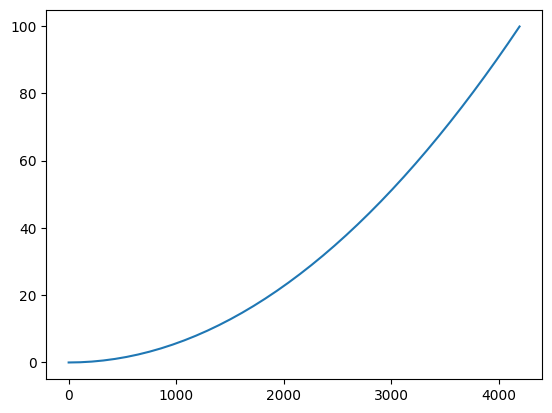

In [73]:
plt.plot(x0, z0)
plt.show()

In [74]:
q0=np.zeros(12*N)

In [75]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [76]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [77]:
root_ = root(static_func, q0, method='df-sane')

In [78]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.202e+02  1.202e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.253e+03  2.360e+03 ...  0.000e+00  0.000e+00]
     nit: 462
    nfev: 1000
  method: df-sane

In [79]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [80]:
# q0 = root_.x                                            # start from static solution

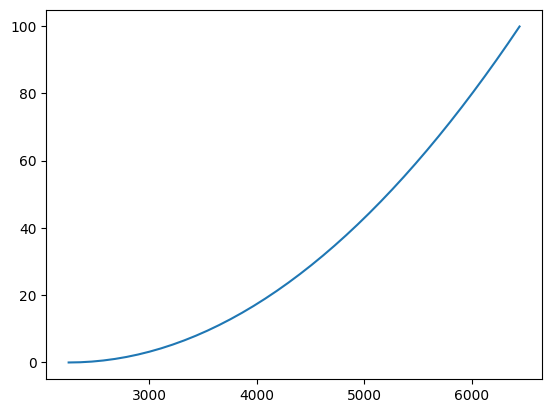

In [81]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [82]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [83]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [84]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [85]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [86]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [87]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [88]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [89]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

#     bc_node = list(range(6))+list(range((len(X)-6),len(X)))
#     bc_val = [0]*6 + vessel_movement
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement

    vessel_move=np.zeros(len(X)*6)
#     vessel_move[-6:]=vessel_movement

    d,f=FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [90]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [91]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.36331141e-09, -5.39962741e-10,  1.28909505e-09],
       [-3.86944521e-09,  4.39746017e-10,  4.72965667e-10],
       [-4.79440132e-09,  7.62906509e-11,  1.39134926e-09],
       [-1.81125870e-09, -8.06323897e-11, -1.28432376e-10],
       [ 2.41197995e-09, -8.85421514e-10, -2.46870968e-10],
       [ 2.51748133e-09, -9.92841365e-10, -1.70047088e-09],
       [ 4.70754458e-09, -3.46829773e-10,  6.67057520e-11],
       [ 5.19867172e-09, -5.13864507e-11, -2.52668997e-11],
       [ 2.54658516e-10,  2.16004992e-12, -1.64959602e-10],
       [-3.30328476e-09, -5.63574076e-10,  1.64504854e-10],
       [-4.87489160e-09,  8.67325656e-12,  6.28006092e-10],
       [-3.24507710e-09,  5.39188250e-10, -5.00591568e-10],
       [-2.63389666e-09, -5.45696821e-11, -4.39968062e-11],
       [ 7.27595761e-11, -1.02511422e-09,  2.10320650e-10],
       [ 3.15776560e-09, -2.97582736e-10,  2.84899215e-10],
       [ 4.02656042e-09,  7.08695325e-10

In [92]:
mom

array([[-2.91403679e-09, -4.12890641e-09, -1.39721124e-09],
       [-2.90397395e-09, -9.03537511e-09,  4.42276438e-10],
       [-2.88136448e-09,  3.21074367e-09,  2.60570232e-10],
       [-2.72038392e-09,  8.92123353e-09, -5.40012479e-10],
       [-2.45166731e-09, -4.85022156e-09,  5.55701263e-10],
       [-1.78253856e-09, -9.24046617e-09, -4.20348867e-10],
       [-1.47966261e-09,  3.70340558e-09,  1.24600774e-10],
       [ 7.87892418e-10,  5.75528247e-09,  2.11684892e-10],
       [ 3.75592890e-11, -2.29090347e-09, -8.73114914e-11],
       [ 1.03858611e-09, -6.62384991e-09, -1.72907466e-10],
       [ 1.88757099e-09,  1.18117605e-09,  1.58252078e-10],
       [ 3.18497939e-09,  5.47970558e-09,  2.67732503e-10],
       [ 4.44765647e-09,  1.08178888e-09,  3.36513040e-10],
       [ 4.93558616e-09, -7.21047400e-09, -5.24710941e-10],
       [ 4.45743353e-09, -9.98738869e-10, -3.94720701e-10],
       [ 3.41667317e-09,  6.64931576e-09,  4.80781637e-10],
       [ 1.48574486e-09,  3.48762796e-10

In [93]:
angle

array([[ 0.01053293, -0.01697935, -0.01461789],
       [ 0.01053291, -0.0167887 , -0.01458858],
       [ 0.01053284, -0.01623372, -0.01450064],
       [ 0.01053266, -0.01534836, -0.01435407],
       [ 0.01053232, -0.01416658, -0.01414887],
       [ 0.01053176, -0.01272233, -0.01388504],
       [ 0.01053094, -0.01104956, -0.01356258],
       [ 0.01052979, -0.00918222, -0.01318148],
       [ 0.01052827, -0.00715428, -0.01274175],
       [ 0.01052631, -0.00499967, -0.01224338],
       [ 0.01052387, -0.00275236, -0.01168637],
       [ 0.01052089, -0.0004463 , -0.01107072],
       [ 0.01051732,  0.00188455, -0.01039642],
       [ 0.01051311,  0.00420624, -0.00966346],
       [ 0.01050819,  0.00648479, -0.00887186],
       [ 0.01050252,  0.00868626, -0.00802159],
       [ 0.01049605,  0.01077666, -0.00711266],
       [ 0.01048871,  0.01272202, -0.00614506],
       [ 0.01048046,  0.01448838, -0.00511878],
       [ 0.01047123,  0.01604175, -0.00403382],
       [ 0.01046099,  0.01734814, -0.002

### Vessle Simulation

In [94]:
sampleTime = 0.001              # sample time [seconds]
Number = 100000                      # number of samples

In [95]:
Number*sampleTime

100.0

In [96]:
vehicle=semisub('DPcontrol',0.1,-0.1,40.0,0,0)

In [97]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [98]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

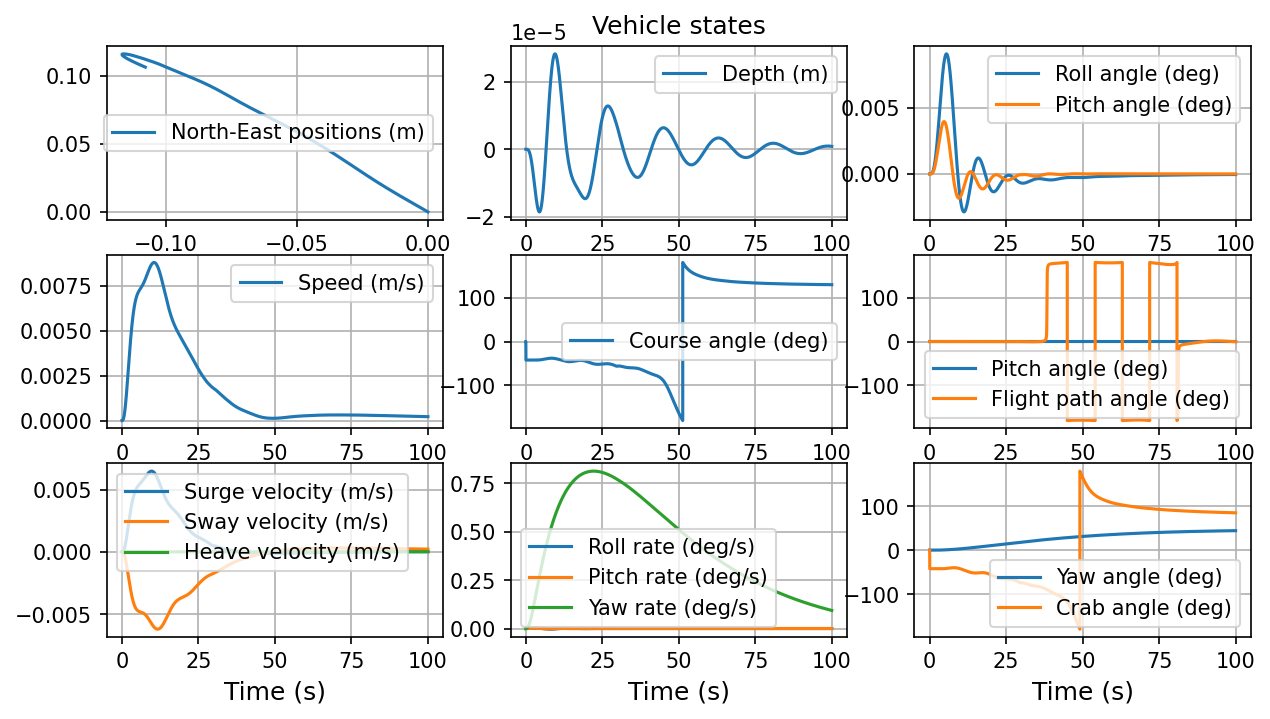

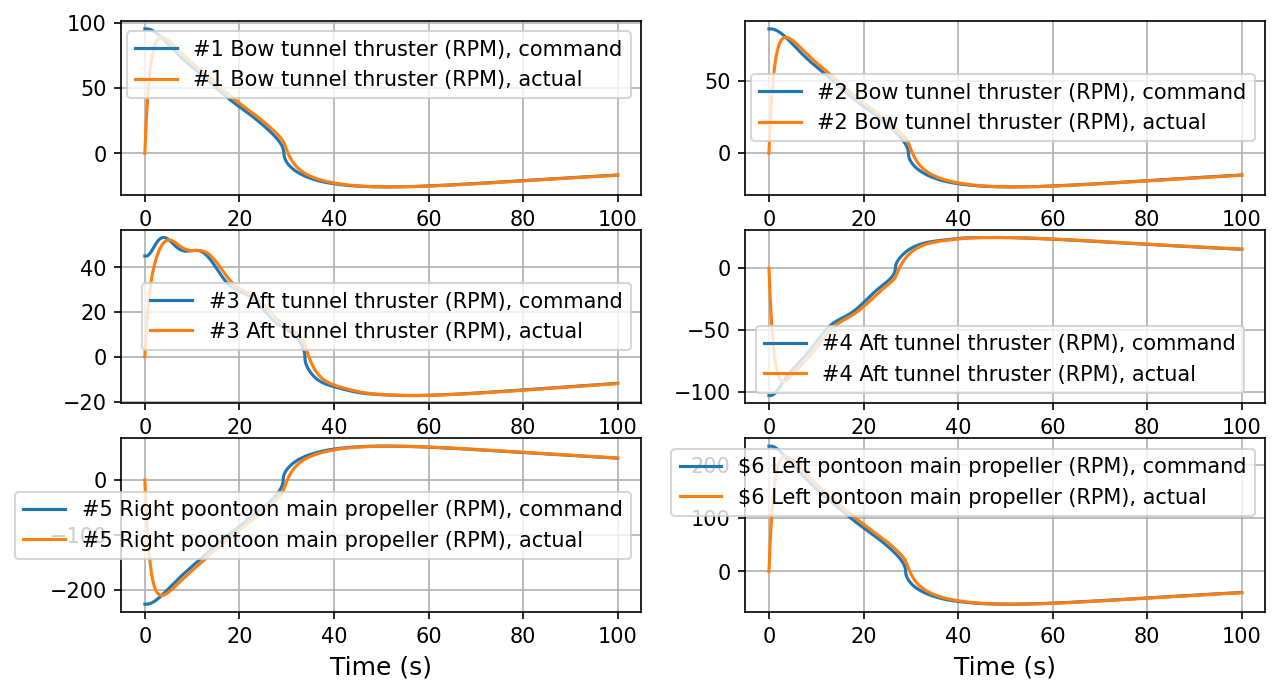

In [99]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [100]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

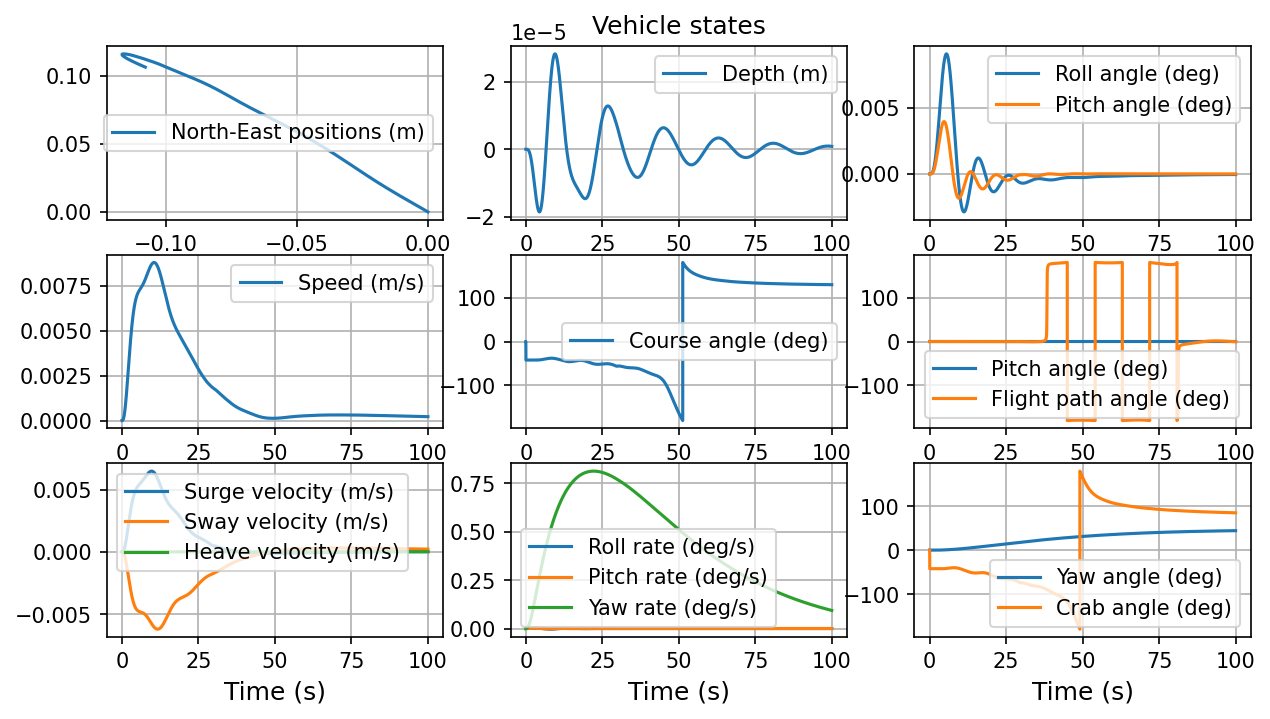

In [101]:
plotVehicleStates(simTime, simData, 3)

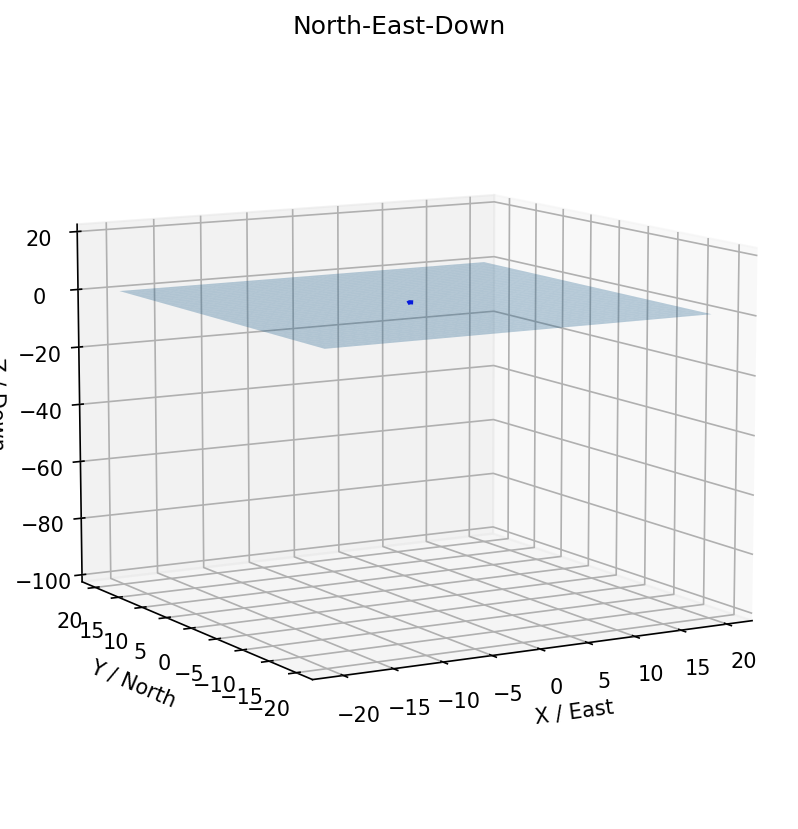

In [102]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [103]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [104]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0

In [105]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [106]:
V_rho=np.zeros(Jrho0.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [107]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [108]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = np.radians(phi_ve - T.phi_ve)
    vessel_movement[4] = np.radians(theta_ve - T.theta_ve)
    vessel_movement[5] = np.radians(psi_ve - T.psi_ve)
    vessel_movement/=calibr
    
    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()
        
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
    
    return ans

In [109]:
# integration parameters
tspan = (0., 50)
T_ = MyTime()
coefs = [1, 1, 1, 1, 1, 1]

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.000236*i/N for i in range(N)]))

In [110]:
vessel_motion_calibration_coefficient = 1

In [111]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  1.0110813220667748e-07  Iteration wall clock time:  0:00:00.786841
Physical time:  1.0138304522633692  Iteration wall clock time:  0:00:48.064592
Physical time:  2.011911689241708  Iteration wall clock time:  0:00:18.037819
Physical time:  3.0452379796739857  Iteration wall clock time:  0:00:19.615607
Physical time:  4.018247126203322  Iteration wall clock time:  0:00:18.702405
Physical time:  5.003217917421204  Iteration wall clock time:  0:00:20.982371
Physical time:  6.011433474444719  Iteration wall clock time:  0:00:20.233314
Physical time:  7.011253565643597  Iteration wall clock time:  0:00:19.917863
Physical time:  8.016439925880729  Iteration wall clock time:  0:00:19.805042
Physical time:  9.008615304603579  Iteration wall clock time:  0:00:18.993288
Physical time:  10.046951549094523  Iteration wall clock time:  0:00:19.408200
Physical time:  11.0326416970261  Iteration wall clock time:  0:00:18.645108
Physical time:  12.031723557152535  Iteration wall clock 

### Results

In [112]:
fin=us_

In [113]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.011e-05 ...  4.991e+01  5.000e+01]
        y: [[ 0.000e+00 -6.292e-27 ...  3.527e-03  3.549e-03]
            [ 1.075e+02  1.075e+02 ...  1.076e+02  1.076e+02]
            ...
            [ 0.000e+00 -4.784e-20 ... -3.194e-08 -3.117e-08]
            [ 0.000e+00  3.746e-22 ... -3.457e-08 -3.373e-08]]
      sol: None
 t_events: None
 y_events: None
     nfev: 2864
     njev: 0
      nlu: 0

In [114]:
t=fin.t

In [115]:
fin=fin.y.T

In [116]:
t.shape, fin.shape

((461,), (461, 480))

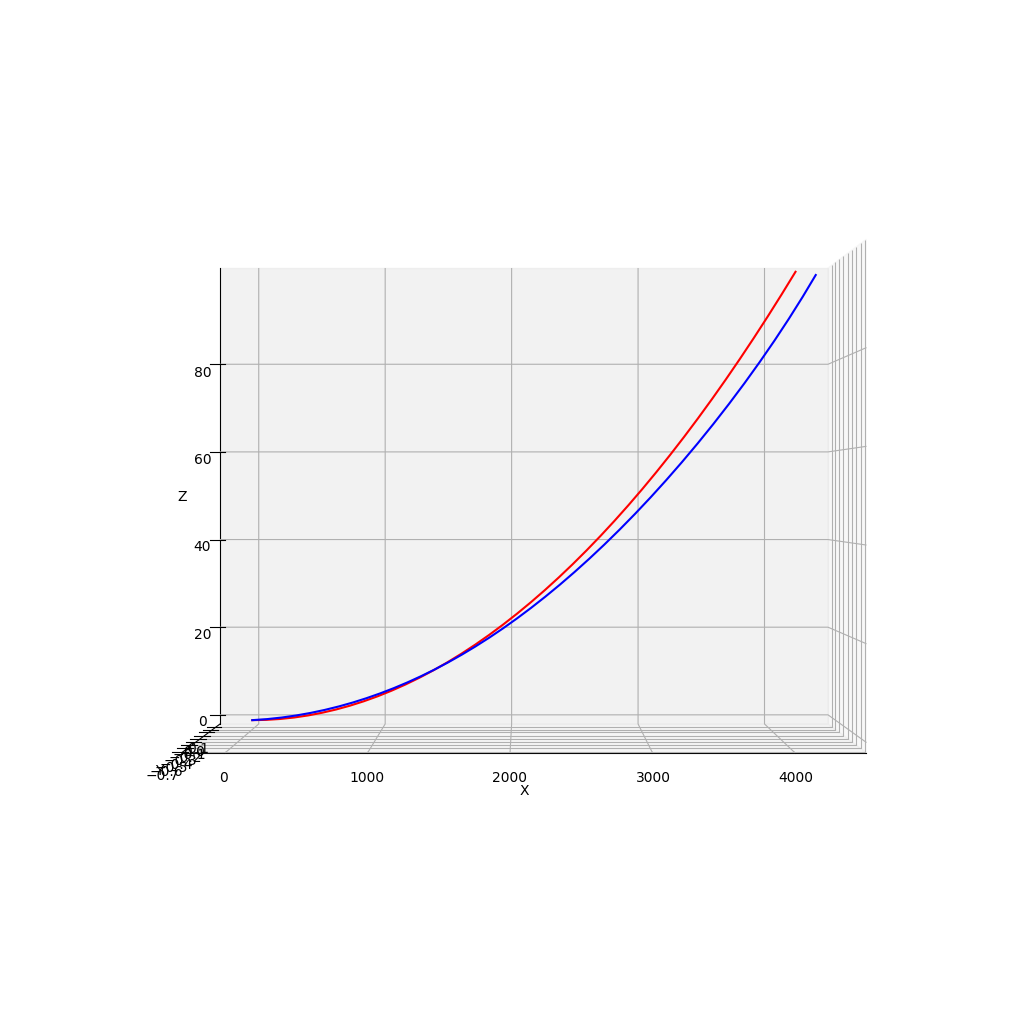

In [117]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [118]:
X,Y,Z

(array([3.54862678e-03, 1.07632092e+02, 2.15241638e+02, 3.22841149e+02,
        4.30435267e+02, 5.38027178e+02, 6.45619311e+02, 7.53213322e+02,
        8.60809975e+02, 9.68409180e+02, 1.07601025e+03, 1.18361228e+03,
        1.29121448e+03, 1.39881618e+03, 1.50641693e+03, 1.61401640e+03,
        1.72161453e+03, 1.82921136e+03, 1.93680677e+03, 2.04440095e+03,
        2.15199398e+03, 2.25958590e+03, 2.36717693e+03, 2.47476721e+03,
        2.58235673e+03, 2.68994574e+03, 2.79753434e+03, 2.90512275e+03,
        3.01271098e+03, 3.12029909e+03, 3.22788732e+03, 3.33547588e+03,
        3.44306468e+03, 3.55065401e+03, 3.65824378e+03, 3.76583429e+03,
        3.87342571e+03, 3.98101776e+03, 4.08861088e+03, 4.19620489e+03]),
 array([ 8.89530032e-07,  2.55669838e-02,  5.00249301e-02,  7.22180185e-02,
         9.16700695e-02,  1.07971517e-01,  1.20775390e-01,  1.29793473e-01,
         1.34792684e-01,  1.35592732e-01,  1.32065956e-01,  1.24136855e-01,
         1.11781542e-01,  9.50281218e-02,  7.39548

In [119]:
X0,Y0,Z0

(array([   0.        ,  107.54459663,  215.08919326,  322.63378989,
         430.17838652,  537.72298315,  645.26757978,  752.81217641,
         860.35677304,  967.90136967, 1075.4459663 , 1182.99056293,
        1290.53515956, 1398.07975619, 1505.62435282, 1613.16894945,
        1720.71354608, 1828.25814271, 1935.80273934, 2043.34733597,
        2150.8919326 , 2258.43652923, 2365.98112586, 2473.52572249,
        2581.07031912, 2688.61491575, 2796.15951238, 2903.70410901,
        3011.24870564, 3118.79330227, 3226.3378989 , 3333.88249552,
        3441.42709215, 3548.97168878, 3656.51628541, 3764.06088204,
        3871.60547867, 3979.1500753 , 4086.69467193, 4194.23926856]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0.00000000e+00, 6.56591421e-02, 2.62636666e-01, 5.90932866e-01,
        1.05054823e+00, 1.64148345e+00, 2.36373939e+00, 3.21

In [120]:
us=fin.T

In [121]:
us.shape

(480, 461)

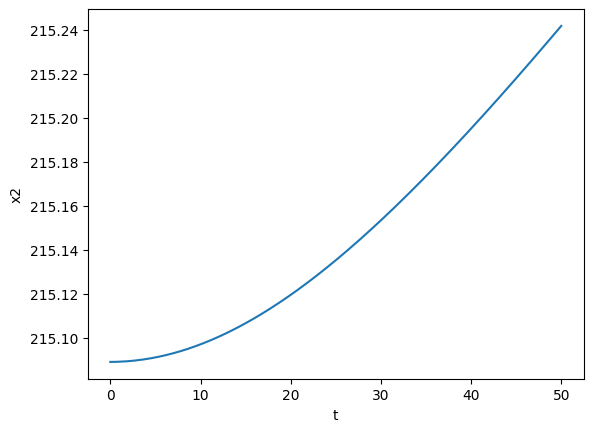

In [122]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

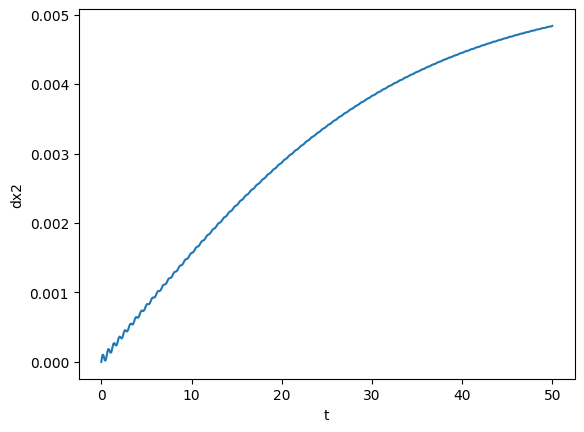

In [123]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

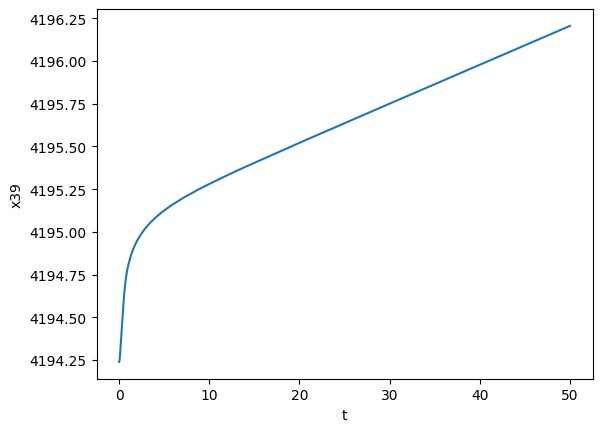

In [124]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

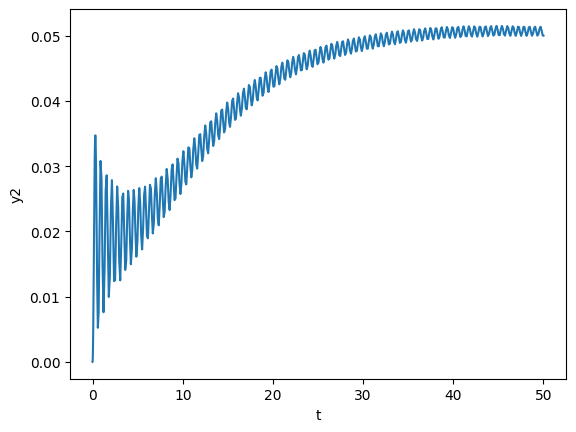

In [125]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

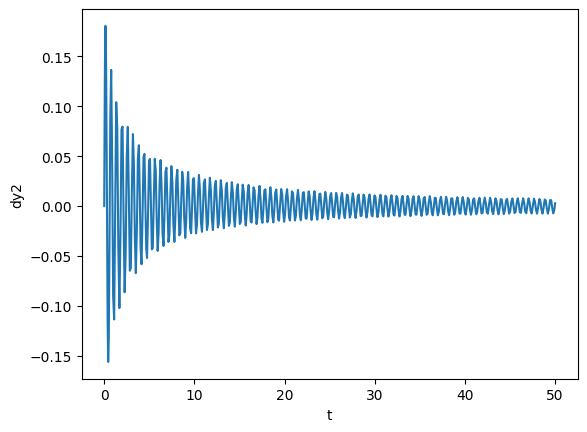

In [126]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

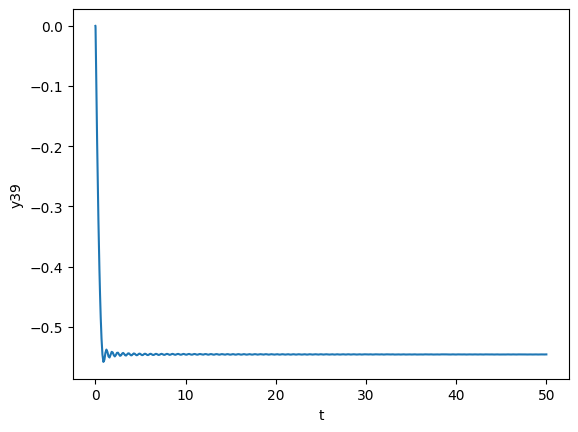

In [127]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

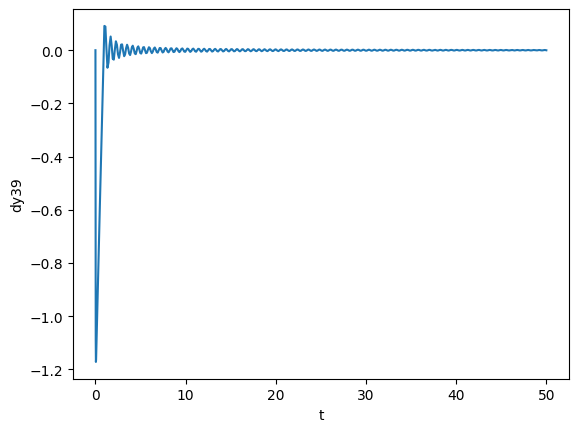

In [128]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

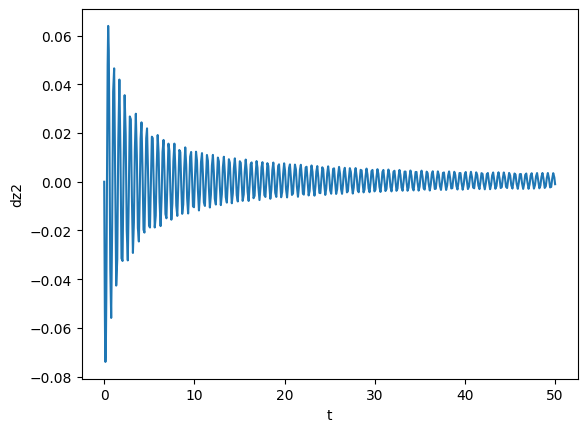

In [129]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

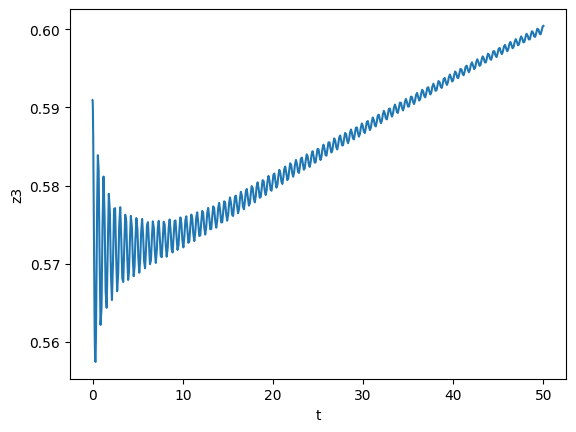

In [130]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

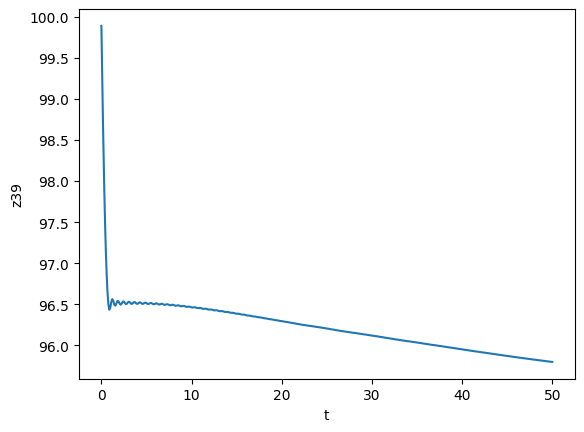

In [131]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

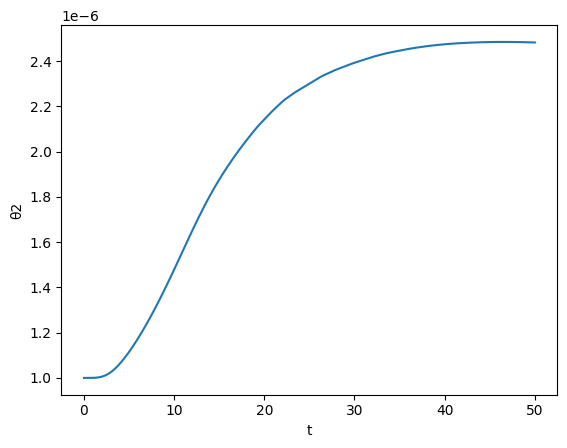

In [132]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

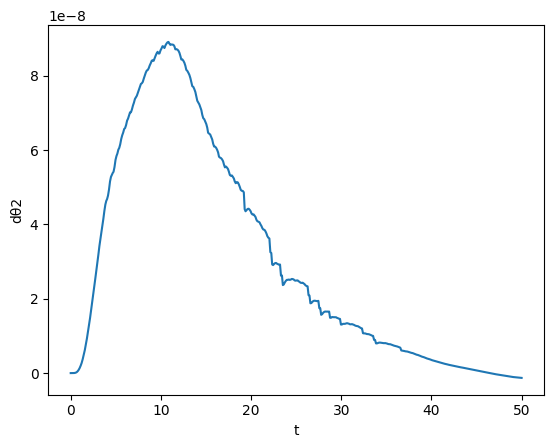

In [133]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

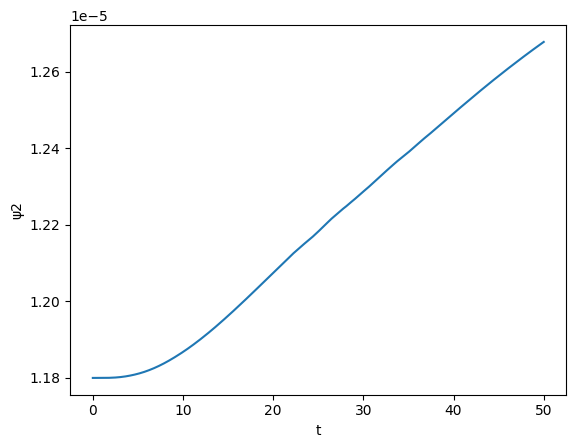

In [134]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

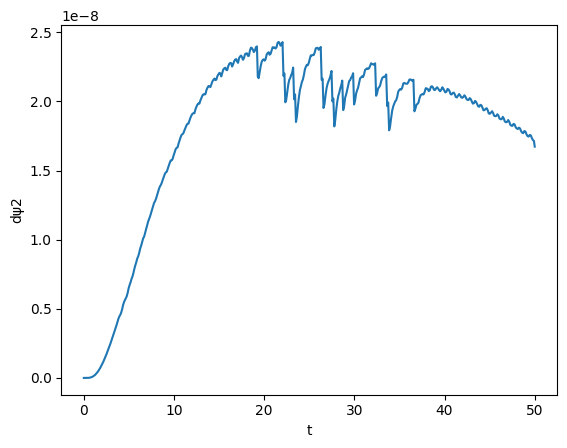

In [135]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

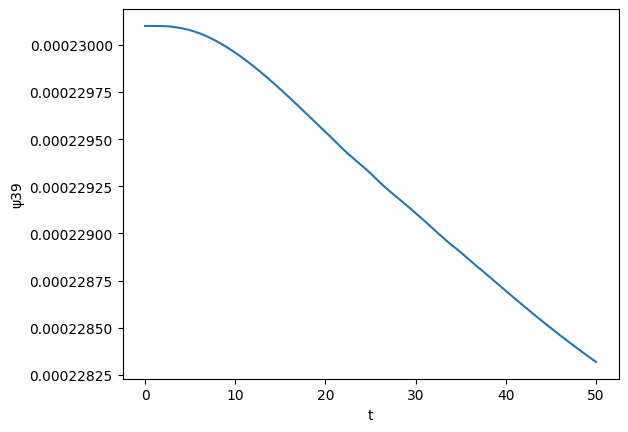

In [136]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()